In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

In [2]:
from tqdm import tqdm, trange

In [3]:
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
df = pd.read_csv('cola_public/raw/in_domain_dev.tsv',delimiter = '\t',header=None,
                 names = ['sentence_source','label','label_notes','sentence'])
df.shape

(527, 4)

In [6]:
df.sample(10)

,sentence_source,label,label_notes,sentence
286,ks08,1,NaN,"Mary likes to tour art galleries, but Bill hat..."
470,sks13,1,NaN,John convinced Bill that Mary should sleep.
167,l-93,1,NaN,Nora sent the book.
510,ad03,0,*,How fierce the battle?
462,sks13,1,NaN,Henry found that Bill is sad.
302,ks08,1,NaN,How did you guess that he fixed the computer?
138,l-93,1,NaN,Martha carved the baby a toy out of wood.
524,ad03,0,*,The bookcase ran
344,c_13,0,*,I hit that you knew the answer.
82,r-67,0,*,The proof this set is recursive is difficult.


In [7]:
sentences = df.sentence.values

sentences = ['[CLS]'+sentence+'[SEP]' for sentence in sentences]

labels =df.label.values

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lowercase=True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

In [9]:
max([len(text) for text in tokenized_texts])

31

In [10]:
MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(input_ids,maxlen = MAX_LEN,dtype='long',truncating='post',padding='post')

In [11]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [12]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids, random_state=2018, test_size=0.1)

In [13]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
try:
    import transformers
except:
    print('Installing Transformers')
    !pip -qq install transformers
from transformers import BertModel, BertConfig
configuration = BertConfig()

model = BertModel(configuration)

configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.4.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



In [16]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [17]:
param_optimizer = list(model.named_parameters())

no_decay = ['bias', 'LayerNorm.weight']

optimizer_grouped_parameters = [{'params' : [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
                               'weight_decay_rate': 0.1},
                                {'params' : [p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
                               'weight_decay_rate': 0.0}]

In [18]:
epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,eps=1e-8)

total_steps =  len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps=total_steps)


In [19]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    labels_flat =labels.flatten()
    return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [20]:
t = []
train_loss_set = []
epochs = 4

for _ in trange(epochs,desc='Epoch'):
    
    model.train()
    
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0,0
    
    for step, batch in enumerate(train_dataloader):
        
        batch = tuple(t.to(device).long() for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        optimizer.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs['loss']
        
        train_loss_set.append(loss.item())
        loss.backward()    
        
        optimizer.step()
        scheduler.step()
        
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
    model.eval()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    
    for batch in validation_dataloader:
        batch = tuple(t.to(device).long() for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
    
        with torch.no_grad():
            
            logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
        
        logits = logits['logits'].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuaracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuaracy
        nb_eval_steps += 1
    
        print('Validation Accuracy: {}'.format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.6694464027881623
Validation Accuracy: 0.75


Epoch:  25%|██▌       | 1/4 [00:11<00:33, 11.02s/it]

Validation Accuracy: 0.78125
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.696875
Train loss: 0.5921153952678044
Validation Accuracy: 0.625


Epoch:  50%|█████     | 2/4 [00:21<00:21, 10.68s/it]

Validation Accuracy: 0.65625
Validation Accuracy: 0.7083333333333334
Validation Accuracy: 0.78125
Train loss: 0.502026038368543
Validation Accuracy: 0.75


Epoch:  75%|███████▌  | 3/4 [00:31<00:10, 10.60s/it]

Validation Accuracy: 0.71875
Validation Accuracy: 0.7291666666666666
Validation Accuracy: 0.796875
Train loss: 0.3980871905883153
Validation Accuracy: 0.875


Epoch: 100%|██████████| 4/4 [00:42<00:00, 10.63s/it]

Validation Accuracy: 0.8125
Validation Accuracy: 0.8333333333333334
Validation Accuracy: 0.825


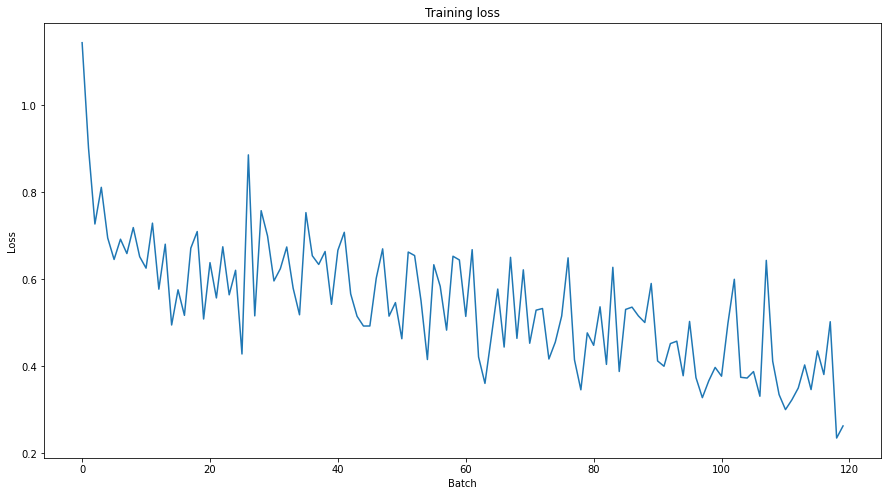

In [21]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [22]:
df = pd.read_csv("cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

sentences = df.sentence.values

sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [23]:
model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader:

    batch = tuple(t.to(device).long() for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
  
    predictions.append(logits)
    true_labels.append(label_ids)

In [24]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

for i in range(len(true_labels)):
    matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
    matthews_set.append(matthews)

matthews_set

C:\Users\katta\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\katta\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\katta\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\katta\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
C:\Users\katta\anaconda3\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[0.0,
 0.0,
 0.6397114734243627,
 0.4127594582445936,
 0.0,
 0.4040950971038548,
 0.21469801604867728,
 -0.06788442333021306,
 0.7453559924999299,
 0.6146362971528592,
 0.7624437362098716,
 0.5673665146135802,
 0.6070347255016324,
 0.2342878320018382,
 0.0,
 0.3567530340063379,
 0.0]

In [25]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.42075304505413436